# NUMBER 1 -  EXTRACTION OF IMAGES AND LABELS FROM FOLDER LOCATION

In [22]:
import os
import cv2
import numpy as np

def load_dataset(folder_path):
    
    images = []
    labels = []

    # Get the list of subfolders (classes) in the folder path
    classes = os.listdir(folder_path)

    for class_name in classes:
        class_folder = os.path.join(folder_path, class_name)
        
        # Iterate through images in the class folder
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            images.append(image_path)
            labels.append(class_name)
    return np.array(images), np.array(labels)

# Path to the dataset folder
train_folder_path = r'C:\Users\olaol\OneDrive\Desktop\SEM B\IMAGE\NEW - data-weed classification\train'
test_folder_path = r'C:\Users\olaol\OneDrive\Desktop\SEM B\IMAGE\NEW - data-weed classification\test'
val_folder_path = r'C:\Users\olaol\OneDrive\Desktop\SEM B\IMAGE\NEW - data-weed classification\val'

train_images, train_labels = load_dataset(train_folder_path)
test_images, test_labels = load_dataset(test_folder_path)
val_images, val_labels = load_dataset(val_folder_path)


print("Number of images in train dataset:", len(train_images))
print("Number of labels:", len(train_labels))
print("Number of images in test dataset:", len(test_images))
print("Number of labels:", len(test_labels))
print("Number of images in validation dataset:", len(val_images))
print("Number of labels:", len(val_labels))

Number of images in train dataset: 480
Number of labels: 480
Number of images in test dataset: 158
Number of labels: 158
Number of images in validation dataset: 148
Number of labels: 148


# NUMBER 2-  IMAGE PREPROCESSING

In [ ]:
# PREPROCESSING STEPS FOR NOW INVOLVES - 
# 1- RESIZING ALL IMAGES TO 256 BY 256 
# 2 -VEGETATION SEGMENTATION
# 2- NOISE REMOVAL - DENOISING USING MEDIANBLUR

In [23]:
from sklearn.preprocessing import LabelEncoder
import cv2
import os
import numpy as np

def preprocess_image(folder_path):
    image_preprocessed = []
    label_image = []

    # Get the list of subfolders (classes) in the folder path
    classes = os.listdir(folder_path)

    for class_name in classes:
        class_folder = os.path.join(folder_path, class_name)
        
        # Iterate through images in the class folder
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            
            # Read the image_path as defined above - this will pass all images in each class folder - train, test, validation
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            # Resize the image
            image = cv2.resize(image, (100, 100))
            
            # Vegetation Segmentation
            image = perform_vegetation_segmentation(image)
                
            # Denoising - Apply median blur for noise removal
            image = cv2.medianBlur(image, 5)  
                    
            # Append the preprocessed image and corresponding label to lists
            image_preprocessed.append(image)
            label_image.append(class_name)
            
    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(label_image)

    return np.array(image_preprocessed), np.array(labels)

def perform_vegetation_segmentation(image):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Define lower and upper bounds for green color in HSV
    lower_green = np.array([10, 0, 0])
    upper_green = np.array([30, 255, 255])
    
    # Create a mask to identify brown regions
    mask = cv2.inRange(hsv_image, lower_green, upper_green)
    
    # Invert the mask
    mask = cv2.bitwise_not(mask)
    
    # Apply the mask to the original image
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    
    return segmented_image

# Path to the dataset folder
train_folder_path = r'C:\Users\olaol\OneDrive\Desktop\SEM B\IMAGE\NEW - data-weed classification\train'
test_folder_path = r'C:\Users\olaol\OneDrive\Desktop\SEM B\IMAGE\NEW - data-weed classification\test'
val_folder_path = r'C:\Users\olaol\OneDrive\Desktop\SEM B\IMAGE\NEW - data-weed classification\val'

# PREPROCESS THE DATA SET
train_images, train_labels = preprocess_image(train_folder_path)
test_images, test_labels = preprocess_image(test_folder_path)
val_images, val_labels = preprocess_image(val_folder_path)

# NUMBER 3 -  FEATURES EXTRACTION

In [ ]:
# FEATURES TO BE EXTRACTED ARE :
# 1) RGB VALUES - USING THE MEAN RGB VALUES
# 2) COLOUR HISTOGRAM
# 3) HISTOGRAM OF GRADIENT FEATURE

# FEATURE 1 - MEAN RGB VALUES

In [24]:
import numpy as np

def extract_mean_rgb_values(images):
    mean_rgb_values = []
    for image in images:
     # Compute the mean RGB value for the image
        mean_rgb = np.mean(image, axis=(0, 1))
        
        # Append the mean RGB value to the empty list above
        mean_rgb_values.append(mean_rgb)

    return mean_rgb_values

mean_rgb_values_train = extract_mean_rgb_values(train_images)
mean_rgb_values_test = extract_mean_rgb_values(test_images)
mean_rgb_values_val = extract_mean_rgb_values(val_images)

# FEATURE 2 - COLOUR HISTOGRAM

In [25]:
import cv2
import numpy as np

def extract_color_histograms(images, bins=(8, 8, 8)):
    histograms = []
    for image in images:
        # Convert the image to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        # Calculate the histogram for each channel
        hist_hue = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 256])
        hist_saturation = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256])
        hist_value = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256])
        # Concatenate the histograms
        histogram = np.concatenate((hist_hue.flatten(), hist_saturation.flatten(), hist_value.flatten()))
        # Normalize the histogram
        histogram /= (image.shape[0] * image.shape[1])  
        histograms.append(histogram)
    return histograms

# Extract color histogram features
histograms_train = extract_color_histograms(train_images)
histograms_test = extract_color_histograms(test_images)
histograms_val = extract_color_histograms(val_images)

# FEATURE 3 - HISTOGRAM OF GRADIENT (HOG)

In [26]:
from skimage.feature import hog
from skimage import exposure

def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Calculate the HOG features
        hog_feature_vector, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                                            cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        # Append the HOG feature vector to the list
        hog_features.append(hog_feature_vector)
    return hog_features

# Extract HOG features
hog_features_train = extract_hog_features(train_images)
hog_features_test = extract_hog_features(test_images)
hog_features_val = extract_hog_features(val_images)

# CONCATENATING THE THREE FEATURES TO TRAIN THE MODELS

In [27]:
import numpy as np

# Concatenate the three features for training data
train_features = np.concatenate((mean_rgb_values_train, histograms_train, hog_features_train), axis=1)

# Concatenate the three features for test data
test_features = np.concatenate((mean_rgb_values_test, histograms_test, hog_features_test), axis=1)

# Concatenate the three features for validation data
val_features = np.concatenate((mean_rgb_values_val, histograms_val, hog_features_val), axis=1)

# CLASSICAL / TRADITIONAL MACHINE LEARNING ALGORITHM

# 1 - SUPPORT VECTOR MACHINE - HYPERPARAMETER TUNING ( TRAINING - VALIDATION - TESTING CYCLE)

In [15]:
# Hyperparameter was tuned using a 5 fold cross validation to select the best parameter using the validation data and then the final 
# evaluation on the test data using the best parameter from the hyperparameter tuning.
# the best model's performance on the validation set using accuracy_score was used to assess
# its performance before testing it on the test set.

Best Hyperparameters: {'C': 10, 'gamma': 0.001}
Validation Accuracy: 0.9054054054054054
Test Accuracy: 0.9050632911392406
Confusion Matrix:
[[83  7]
 [ 8 60]]
Classification Report:
              precision    recall  f1-score   support

    Charlock       0.91      0.92      0.92        90
    Cleavers       0.90      0.88      0.89        68

    accuracy                           0.91       158
   macro avg       0.90      0.90      0.90       158
weighted avg       0.90      0.91      0.90       158



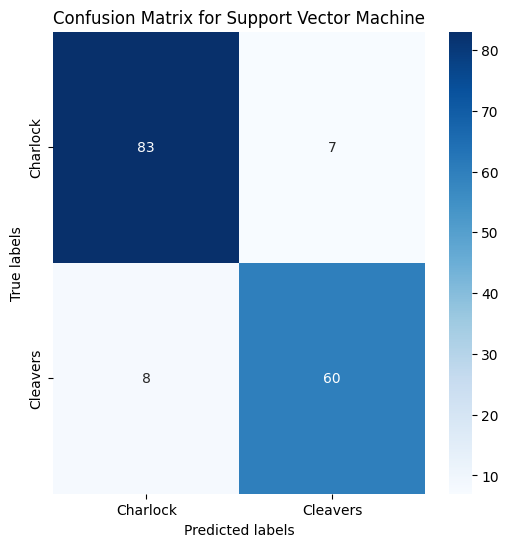

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'C': [0.1, 1, 10],  
    'gamma': [0.001, 0.01, 0.1] 
}

# Initialize model (SVM classifier)
svm = SVC()

#  GridSearchCV with the model and hyperparameters grid using 5 fold cross validation
grid_search = GridSearchCV(svm, param_grid, cv=5)

# fitting the model on training data
grid_search.fit(train_features, train_labels)

# the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model using the best hyperparameters on the entire training data
best_svm = SVC(**best_params)
best_svm.fit(train_features, train_labels)

# Evaluate the final model on the validation data
validation_accuracy = best_svm.score(val_features, val_labels)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the final model on the test data
test_accuracy = best_svm.score(test_features, test_labels)
print("Test Accuracy:", test_accuracy)

# Calculate and print the confusion matrix on the test data
test_predictions = best_svm.predict(test_features)
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report on the test data
print("Classification Report:")
print(classification_report(test_labels, test_predictions,target_names = ['Charlock', 'Cleavers']))

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Support Vector Machine')
plt.show()

# 2 - LOGISTIC REGRESSION - HYPERPARAMETER TUNING ( TRAINING - VALIDATION - TESTING CYCLE)

Best Hyperparameters: {'C': 0.1, 'solver': 'liblinear'}
Validation Accuracy: 0.8986486486486487
Test Accuracy: 0.8987341772151899
Confusion Matrix:
[[83  7]
 [ 9 59]]
Classification Report:
              precision    recall  f1-score   support

    Charlock       0.90      0.92      0.91        90
    Cleavers       0.89      0.87      0.88        68

    accuracy                           0.90       158
   macro avg       0.90      0.89      0.90       158
weighted avg       0.90      0.90      0.90       158



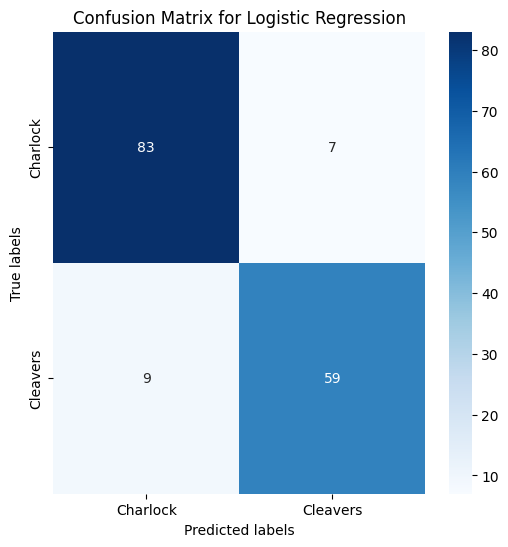

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
    
}

# Initialize model (Logistic Regression classifier)
log_reg = LogisticRegression(max_iter = 10000)

#  GridSearchCV with the model and hyperparameters grid using 5 fold cross validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5)

# fitting the model on training data
grid_search.fit(train_features, train_labels)

# the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model using the best hyperparameters on the entire training data
best_log_reg = LogisticRegression(**best_params)
best_log_reg.fit(train_features, train_labels)

# Evaluate the final model on the validation data
validation_accuracy = best_log_reg.score(val_features, val_labels)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the final model on the test data
test_accuracy = best_log_reg.score(test_features, test_labels)
print("Test Accuracy:", test_accuracy)

# Calculate and print the confusion matrix on the test data
test_predictions = best_log_reg.predict(test_features)
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report on the test data
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names = ['Charlock', 'Cleavers']))

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels = ['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# 3 - RANDOM FOREST

Best Hyperparameters: {'max_depth': None, 'n_estimators': 150}
Validation Accuracy: 0.8716216216216216
Test Accuracy: 0.879746835443038
Confusion Matrix:
[[84  6]
 [13 55]]
Classification Report:
              precision    recall  f1-score   support

    Charlock       0.87      0.93      0.90        90
    Cleavers       0.90      0.81      0.85        68

    accuracy                           0.88       158
   macro avg       0.88      0.87      0.88       158
weighted avg       0.88      0.88      0.88       158



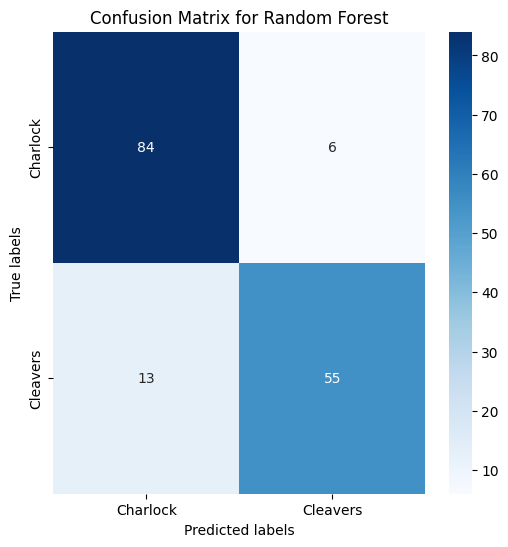

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 30]
}

# Initialize model (Random Forest classifier)
rf = RandomForestClassifier()

# GridSearchCV with the model and hyperparameters grid using 5 fold cross validation
grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fitting the model on training data
grid_search.fit(train_features, train_labels)

# The best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model using the best hyperparameters on the entire training data
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(train_features, train_labels)

# Evaluate the final model on the validation data
validation_accuracy = best_rf.score(val_features, val_labels)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the final model on the test data
test_accuracy = best_rf.score(test_features, test_labels)
print("Test Accuracy:", test_accuracy)

# Calculate and print the confusion matrix on the test data
test_predictions = best_rf.predict(test_features)
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report on the test data
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Charlock', 'Cleavers']))

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# ENSEMBLE TECHNIQUE USING VOTING CLASSIFIER

Test Accuracy (Ensemble): 0.9113924050632911
Classification Report:
              precision    recall  f1-score   support

    Charlock       0.90      0.94      0.92        90
    Cleavers       0.92      0.87      0.89        68

    accuracy                           0.91       158
   macro avg       0.91      0.91      0.91       158
weighted avg       0.91      0.91      0.91       158

Confusion Matrix:
[[85  5]
 [ 9 59]]


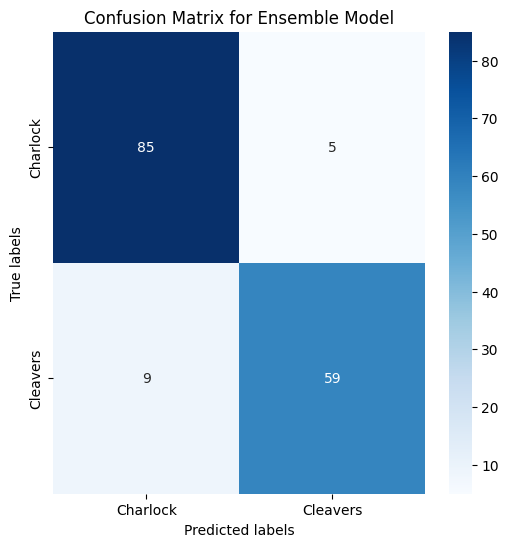

In [71]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Define the estimators with their best hyperparameters
estimators = [
    ('svm', SVC(C=10, gamma=0.001)),
    ('random_forest', RandomForestClassifier(n_estimators=150, max_depth=None)),
    ('logistic_regression', LogisticRegression(C=0.1, solver='liblinear'))
]

# Create the voting classifier
voting_classifier = VotingClassifier(estimators)

# Train the voting classifier on the training data
voting_classifier.fit(train_features, train_labels)


# Evaluate the voting classifier on the test data
test_predictions = voting_classifier.predict(test_features)
test_accuracy = voting_classifier.score(test_features, test_labels)
print("Test Accuracy (Ensemble):", test_accuracy)

# Print the classification report on the test data
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Charlock', 'Cleavers']))

# Calculate and print the confusion matrix on the test data
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()

# DEEP LEARNING

# FULLY CONNECTED NEURAL NETWORK

Epoch 1/15


C:\Users\olaol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5898 - loss: 0.6886 - val_accuracy: 0.8041 - val_loss: 0.4364
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8412 - loss: 0.3842 - val_accuracy: 0.8378 - val_loss: 0.3739
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8691 - loss: 0.3111 - val_accuracy: 0.8649 - val_loss: 0.3610
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8883 - loss: 0.2795 - val_accuracy: 0.8581 - val_loss: 0.3502
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8996 - loss: 0.2524 - val_accuracy: 0.8649 - val_loss: 0.3438
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9186 - loss: 0.2320 - val_accuracy: 0.8851 - val_loss: 0.3387
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9252 - loss: 0.2158 - val_accuracy: 0.8784 - val_loss: 0.3340
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9319 - loss: 0.2019 - val_accuracy: 0.8851 - val_loss: 0.3312
E

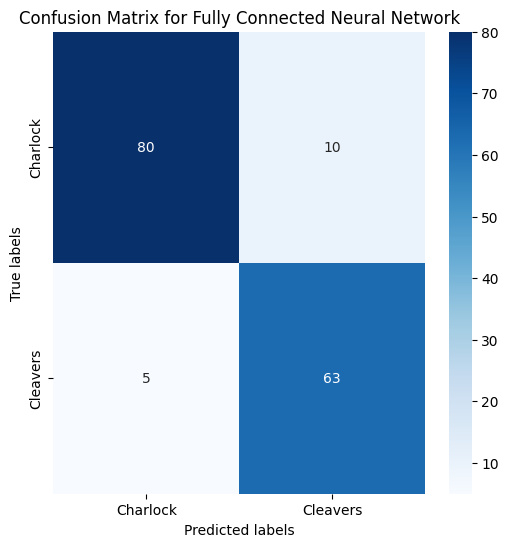

In [80]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical

# Training the fully connected neural network with the color histogram feature above
histograms_train = np.array(histograms_train)
histograms_test = np.array(histograms_test)
histograms_val = np.array(histograms_val)

# Reshape histograms to make them compatible with the neural network
histograms_train_flattened = histograms_train.reshape(histograms_train.shape[0], -1)
histograms_test_flattened = histograms_test.reshape(histograms_test.shape[0], -1)
histograms_val_flattened = histograms_val.reshape(histograms_val.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(histograms_train_flattened)
test_features_scaled = scaler.transform(histograms_test_flattened)
val_features_scaled = scaler.transform(histograms_val_flattened)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Define a simple fully connected neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(train_features_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_features_scaled, train_labels_encoded, epochs=15, batch_size=32, validation_data=(val_features_scaled, val_labels_encoded))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_features_scaled, test_labels_encoded)
print("Test Accuracy:", test_accuracy)

# Predict on the test data
test_predictions = np.round(model.predict(test_features_scaled)).flatten()

# Print classification report
target_names = ['charlock', 'cleavers']
print("Classification Report:")
print(classification_report(test_labels_encoded, test_predictions, target_names=target_names))

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fully Connected Neural Network')
plt.show()

# CONVOLUTIONAL NEURAL NETWORK

C:\Users\olaol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9657 - loss: 0.1632
Test accuracy: 0.9556962251663208
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
              precision    recall  f1-score   support

    charlock       0.96      0.97      0.96        90
    cleavers       0.96      0.94      0.95        68

    accuracy                           0.96       158
   macro avg       0.96      0.95      0.95       158
weighted avg       0.96      0.96      0.96       158



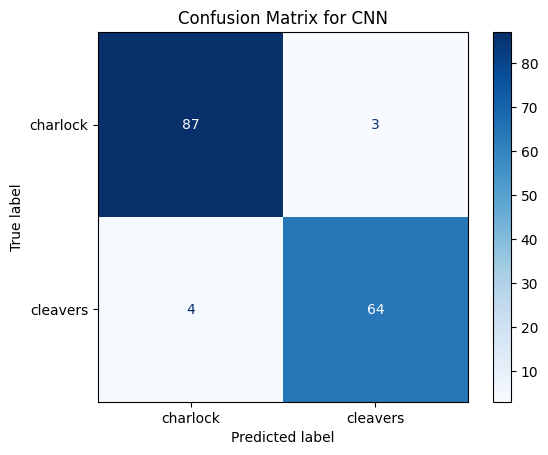

In [39]:
import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Define the CNN model
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu')
    ])
    return model

# Define the model input shapes
input_shape = (100, 100, 3)  
num_classes = 2 
num_bins = 8  

# Create the CNN model
cnn_model = create_model(input_shape)

# Define input layer for images
input_img = layers.Input(shape=input_shape)

# Pass input_img through the CNN model
cnn_output = cnn_model(input_img)

# Define input layer for color histogram features
input_hist = layers.Input(shape=(num_bins * 3,))  

# Concatenate CNN output with color histogram features
concatenated = layers.concatenate([cnn_output, input_hist])

# more dense layers for classification
concatenated = layers.Dense(256, activation='relu')(concatenated)
output = layers.Dense(1, activation='sigmoid')(concatenated)

# the final model
model = models.Model(inputs=[input_img, input_hist], outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
tf.random.set_seed(42)
history = model.fit(
    [train_images, histograms_train], train_labels,
    epochs=15,
    validation_data=([val_images, histograms_val], val_labels),
    shuffle=True,  # Shuffle the training data with a fixed seed
    verbose=0  # Suppress the training output for cleaner display
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate([test_images, histograms_test], test_labels)
print('Test accuracy:', test_acc)

# Predict labels for the test set
y_pred = model.predict([test_images, histograms_test]).flatten()
y_pred = np.round(y_pred)

# Print classification report
target_names= ['charlock', 'cleavers']
print(classification_report(test_labels, y_pred, target_names=target_names))

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["charlock", "cleavers"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN')
plt.show()